In [1]:
# installing required libraries
!pip install requests pandas

In [2]:
#Setting up API key and importing Libraries
import requests
import pandas as pd
import time  # To add delay to API calls if necessary


In [3]:
#Automating data collection for MICROSOFT, TESLA, GOOGLE
def get_stock_data(symbol, api_key):
    url = f'https://www.alphavantage.co/query'
    params = {
        'function': 'TIME_SERIES_DAILY_ADJUSTED',
        'symbol': symbol,
        'outputsize': 'full',  # to get as much historical data as possible
        'apikey': api_key
    }
    response = requests.get(url, params=params)
    data = response.json()

    # Parse JSON and structure it in DataFrame format
    if "Time Series (Daily)" in data:
        daily_data = data["Time Series (Daily)"]
        df = pd.DataFrame.from_dict(daily_data, orient='index')
        df = df.rename(columns={
            "1. open": "Open",
            "2. high": "High",
            "3. low": "Low",
            "4. close": "Close",
            "5. adjusted close": "Adjusted Close",
            "6. volume": "Volume",
            "7. dividend amount": "Dividend Amount",
            "8. split coefficient": "Split Coefficient"
        })

        # Convert index to datetime
        df.index = pd.to_datetime(df.index)
        df = df.sort_index()  # Sort by date ascending

        # Select and convert columns to numeric
        for col in ["Open", "High", "Low", "Close", "Adjusted Close", "Volume"]:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        return df
    else:
        print(f"Error fetching data for {symbol}: {data}")
        return None



In [4]:
#Fetching and saving data for each stock
#adding api key and collecting data for each stock
#Saving data to CSV for use

api_key = 'QML8LTFHWEDRTJBS'  # Replace with your Alpha Vantage API key

# List of stock symbols
symbols = ['MSFT', 'TSLA', 'GOOGL']

# Dictionary to hold each stock's data
stock_data = {}

for symbol in symbols:
    print(f"Fetching data for {symbol}...")
    df = get_stock_data(symbol, api_key)
    if df is not None:
        stock_data[symbol] = df
        # Save each stock's data as a CSV file
        df.to_csv(f'{symbol}_stock_data.csv')
        print(f"Data for {symbol} saved successfully.")

    # Respect API rate limits
    time.sleep(12)  # 12 seconds delay for free Alpha Vantage API (5 calls/minute)




Fetching data for MSFT...
Data for MSFT saved successfully.
Fetching data for TSLA...
Data for TSLA saved successfully.
Fetching data for GOOGL...
Data for GOOGL saved successfully.


In [5]:
!pip install alpha_vantage


In [6]:
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import time

# Replace 'YOUR_API_KEY' with your actual Alpha Vantage API key
api_key = 'QML8LTFHWEDRTJBS'
ts = TimeSeries(key=api_key, output_format='pandas')

# Define a function to fetch data and add moving averages
def get_stock_data_with_indicators(symbol):
    # Fetch daily adjusted stock data
    data, meta_data = ts.get_daily_adjusted(symbol=symbol, outputsize='full')

    # Sort data by date in ascending order
    data = data.sort_index(ascending=True)

    # Calculate 50-day and 200-day moving averages
    data['MA_50'] = data['5. adjusted close'].rolling(window=50).mean()
    data['MA_200'] = data['5. adjusted close'].rolling(window=200).mean()

    return data

# Fetch data for each stock and calculate moving averages
msft_data = get_stock_data_with_indicators('MSFT')
tsla_data = get_stock_data_with_indicators('TSLA')
googl_data = get_stock_data_with_indicators('GOOGL')

# Save the updated data with moving averages to CSV files
msft_data.to_csv('MSFT_stock_data_with_indicators.csv')
tsla_data.to_csv('TSLA_stock_data_with_indicators.csv')
googl_data.to_csv('GOOGL_stock_data_with_indicators.csv')

print("Data collection and moving averages calculation complete.")


Data collection and moving averages calculation complete.


In [7]:
# DATA PREPROCESSING STEPS

In [8]:
#Loading Data
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load your saved CSV data
msft_data = pd.read_csv('MSFT_stock_data_with_indicators.csv', index_col='date', parse_dates=True)
tsla_data = pd.read_csv('TSLA_stock_data_with_indicators.csv', index_col='date', parse_dates=True)
googl_data = pd.read_csv('GOOGL_stock_data_with_indicators.csv', index_col='date', parse_dates=True)


In [9]:
# Showing basic information about the data

print("Microsoft data:\n", msft_data.head())
print("Tesla data:\n", tsla_data.head())
print("Google data:\n", googl_data.head())


Microsoft data:
             1. open  2. high  3. low  4. close  5. adjusted close   6. volume  \
date                                                                            
1999-11-01    93.25    94.19   92.12     92.37          28.538016  26630600.0   
1999-11-02    92.75    94.50   91.94     92.56          28.596717  23174500.0   
1999-11-03    92.94    93.50   91.50     92.00          28.423703  22258500.0   
1999-11-04    92.31    92.75   90.31     91.75          28.346465  27119700.0   
1999-11-05    91.81    92.87   90.50     91.56          28.287764  35083700.0   

            7. dividend amount  8. split coefficient  MA_50  MA_200  
date                                                                 
1999-11-01                 0.0                   1.0    NaN     NaN  
1999-11-02                 0.0                   1.0    NaN     NaN  
1999-11-03                 0.0                   1.0    NaN     NaN  
1999-11-04                 0.0                   1.0    NaN     N

In [10]:
#Handling missing values

msft_data = msft_data.dropna()
tsla_data = tsla_data.dropna()
googl_data = googl_data.dropna()


In [11]:
#Normalizing or scaling

scaler = MinMaxScaler(feature_range=(0, 1))

In [12]:
# Select columns for normalization
msft_data_scaled = pd.DataFrame(scaler.fit_transform(msft_data), columns=msft_data.columns, index=msft_data.index)
tsla_data_scaled = pd.DataFrame(scaler.fit_transform(tsla_data), columns=tsla_data.columns, index=tsla_data.index)
googl_data_scaled = pd.DataFrame(scaler.fit_transform(googl_data), columns=googl_data.columns, index=googl_data.index)


In [13]:
#Train-Test split
# Define the split ratio (e.g., 80% train, 10% validation, 10% test)
train_size = int(len(msft_data_scaled) * 0.8)
val_size = int(len(msft_data_scaled) * 0.1)

In [14]:
# Microsoft
msft_train = msft_data_scaled[:train_size]
msft_val = msft_data_scaled[train_size:train_size+val_size]
msft_test = msft_data_scaled[train_size+val_size:]

# Tesla
tsla_train = tsla_data_scaled[:train_size]
tsla_val = tsla_data_scaled[train_size:train_size+val_size]
tsla_test = tsla_data_scaled[train_size+val_size:]

# Google
googl_train = googl_data_scaled[:train_size]
googl_val = googl_data_scaled[train_size:train_size+val_size]
googl_test = googl_data_scaled[train_size+val_size:]

print("Data Preprocessing Complete!")


Data Preprocessing Complete!


In [15]:
#Model Development

In [16]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [17]:
# Hyperparameters
time_steps = 60  # Number of time steps to consider for each sequence (e.g., 60 days of history)
batch_size = 32
epochs = 50

In [18]:
# Function to create sequences
def create_sequences(data, time_steps=60):
    sequences = []
    labels = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])
        labels.append(data[i + time_steps, 0])  # Assuming we are predicting the first column (e.g., closing price)
    return np.array(sequences), np.array(labels)

In [19]:
# Apply to training data
x_train, y_train = create_sequences(msft_train.values, time_steps)
x_val, y_val = create_sequences(msft_val.values, time_steps)
x_test, y_test = create_sequences(msft_test.values, time_steps)

In [20]:
# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Output layer for predicting the stock price
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [22]:
# Train model
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(x_val, y_val), verbose=1)


Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 24s 92ms/step - loss: 0.0013 - val_loss: 0.0066
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 8.6463e-05 - val_loss: 0.0061
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 8.1689e-05 - val_loss: 0.0055
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 5.8461e-05 - val_loss: 0.0037
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 6.1561e-05 - val_loss: 0.0054
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 4.5377e-05 - val_loss: 0.0046
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 5.2515e-05 - val_loss: 0.0065
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 4.2952e-05 - val_loss: 0.0072
Epoch 9/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 3.9909e-05 - val_loss: 0.0064
Epoch 10/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 4.4665e-05 - val_loss: 0.0070
Epoch 11/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - loss: 4.3584e-05 - val_loss: 0.00

In [23]:
# Evaluate model on test data
test_loss = model.evaluate(x_test, y_test, verbose=0)
print("Test Loss:", test_loss)

Test Loss: 0.02634391561150551


In [24]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Hyperparameters
time_steps = 60  # Number of time steps to consider for each sequence (e.g., 60 days of history)
batch_size = 32
epochs = 50

# Function to create sequences
def create_sequences(data, time_steps=60):
    sequences = []
    labels = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])
        labels.append(data[i + time_steps, 0])  # Assuming we are predicting the first column (e.g., closing price)
    return np.array(sequences), np.array(labels)

# Assume msft_train, msft_val, and msft_test are already defined and scaled

# Apply to training data
x_train, y_train = create_sequences(msft_train.values, time_steps)
x_val, y_val = create_sequences(msft_val.values, time_steps)
x_test, y_test = create_sequences(msft_test.values, time_steps)

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Output layer for predicting the stock price
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(x_val, y_val), verbose=1)

# Evaluate model on test data
test_loss = model.evaluate(x_test, y_test, verbose=0)
print("Test Loss:", test_loss)

# Make predictions on the test set
predictions = model.predict(x_test)

# Now you can proceed to calculate MAE and MSE as needed
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print(f'Mean Absolute Error: {mae:.4f}')
print(f'Mean Squared Error: {mse:.4f}')


Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 1.0084e-04 - val_loss: 8.7642e-04
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 7.9922e-05 - val_loss: 0.0027
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 5.4094e-05 - val_loss: 0.0015
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 5.3331e-05 - val_loss: 8.3982e-04
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 4.7042e-05 - val_loss: 0.0016
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 4.9815e-05 - val_loss: 0.0014
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 4.7641e-05 - val_loss: 0.0036
Epoch 9/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 5.3633e-05 - val_loss: 0.0012
Epoch 10/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 4.0996e-05 - val_loss: 0.0014
Epoch 11/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 4.9981e-05 - val

In [25]:
#Visualizing Predictions

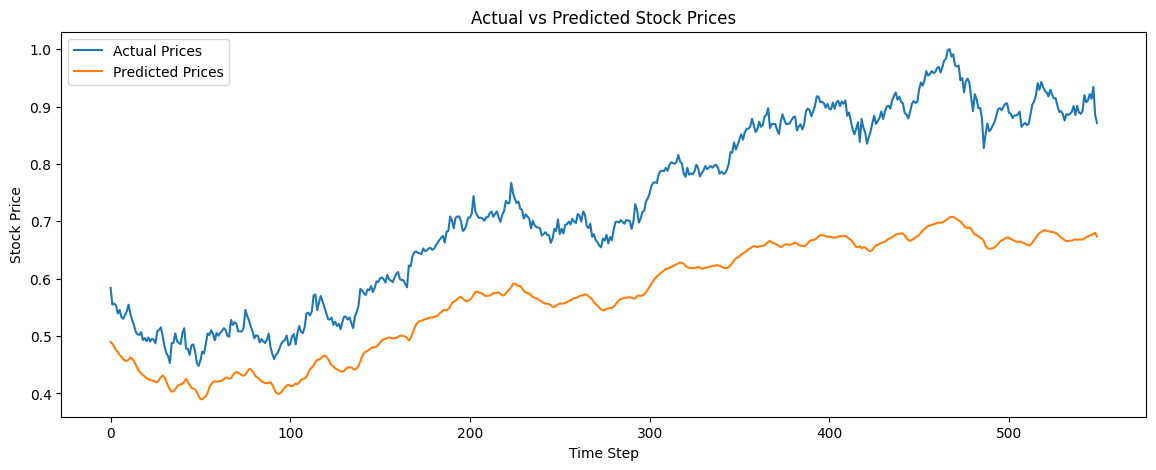

In [26]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted values
plt.figure(figsize=(14, 5))
plt.plot(y_test, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [27]:
# Adjusting hyperparamters to see better results on our visualization by using 60 days of history vs 30, and increasing batch size to 128
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Hyperparameters
time_steps = 60  # Number of time steps to consider for each sequence (e.g., 60 days of history)
batch_size = 64
epochs = 50

# Function to create sequences
def create_sequences(data, time_steps=60):
    sequences = []
    labels = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])
        labels.append(data[i + time_steps, 0])  # Assuming we are predicting the first column (e.g., closing price)
    return np.array(sequences), np.array(labels)

# Assume msft_train, msft_val, and msft_test are already defined and scaled

# Apply to training data
x_train, y_train = create_sequences(msft_train.values, time_steps)
x_val, y_val = create_sequences(msft_val.values, time_steps)
x_test, y_test = create_sequences(msft_test.values, time_steps)

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Output layer for predicting the stock price
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(x_val, y_val), verbose=1)

# Evaluate model on test data
test_loss = model.evaluate(x_test, y_test, verbose=0)
print("Test Loss:", test_loss)

# Make predictions on the test set
predictions = model.predict(x_test)

# Now you can proceed to calculate MAE and MSE as needed
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print(f'Mean Absolute Error: {mae:.4f}')
print(f'Mean Squared Error: {mse:.4f}')


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 6.7283e-04 - val_loss: 0.0075
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 9.0816e-05 - val_loss: 0.0038
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 7.4920e-05 - val_loss: 0.0052
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 6.7065e-05 - val_loss: 0.0046
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 6.0765e-05 - val_loss: 0.0022
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 5.1035e-05 - val_loss: 0.0042
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 5.6102e-05 - val_loss: 0.0047
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 4.6381e-05 - val_loss: 0.0049
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 4.4573e-05 - val_loss: 0.0042
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 4.1058e-05 - val_loss: 0.0048
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 4.2760e-05 - val_loss: 0.0029
Epoch 12/50
76/76 ━━━━━━━━━

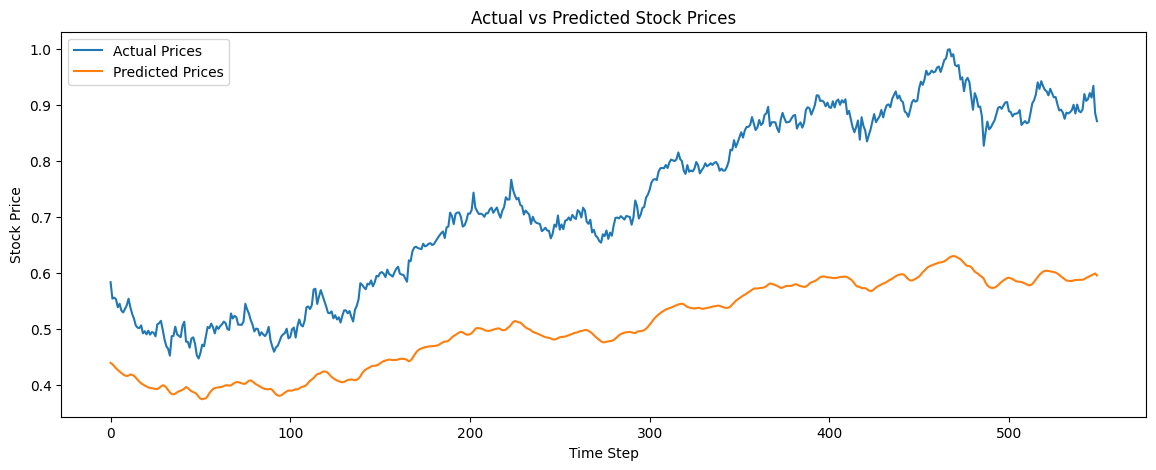

In [28]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted values
plt.figure(figsize=(14, 5))
plt.plot(y_test, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# My Add-Ons

## 1. Line Plot with Confidence Interval
This plot shows the actual vs. predicted prices as line plots with a confidence interval shaded area around the predicted values.

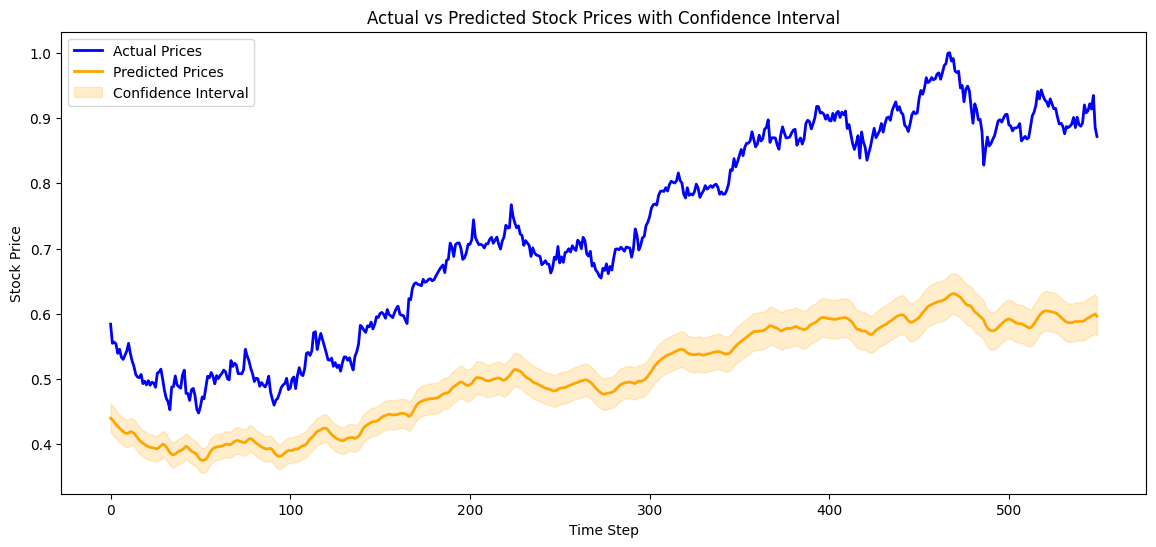

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # import moved here for clarity

# Assuming y_test and predictions are available
error_margin = 0.05 * predictions  # Example 5% error margin

# Create data for Seaborn
# Convert 'Predicted Prices' to 1-dimensional array using flatten()
data = {
    'Time Step': np.arange(len(y_test)),
    'Actual Prices': y_test,
    'Predicted Prices': predictions.flatten() # Changed to flatten predictions
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Plot with confidence interval
plt.figure(figsize=(14, 6))
sns.lineplot(x='Time Step', y='Actual Prices', data=df, label='Actual Prices', color='blue', linewidth=2)
sns.lineplot(x='Time Step', y='Predicted Prices', data=df, label='Predicted Prices', color='orange', linewidth=2)
plt.fill_between(df['Time Step'], df['Predicted Prices'] - error_margin.flatten(), df['Predicted Prices'] + error_margin.flatten(),  #flatten error_margin also
                 color='orange', alpha=0.2, label='Confidence Interval')
plt.title('Actual vs Predicted Stock Prices with Confidence Interval')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend(loc='upper left')
plt.show()

## 2. Residuals Plot
A residuals plot helps assess the difference between actual and predicted values, allowing you to check for patterns in the residuals.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


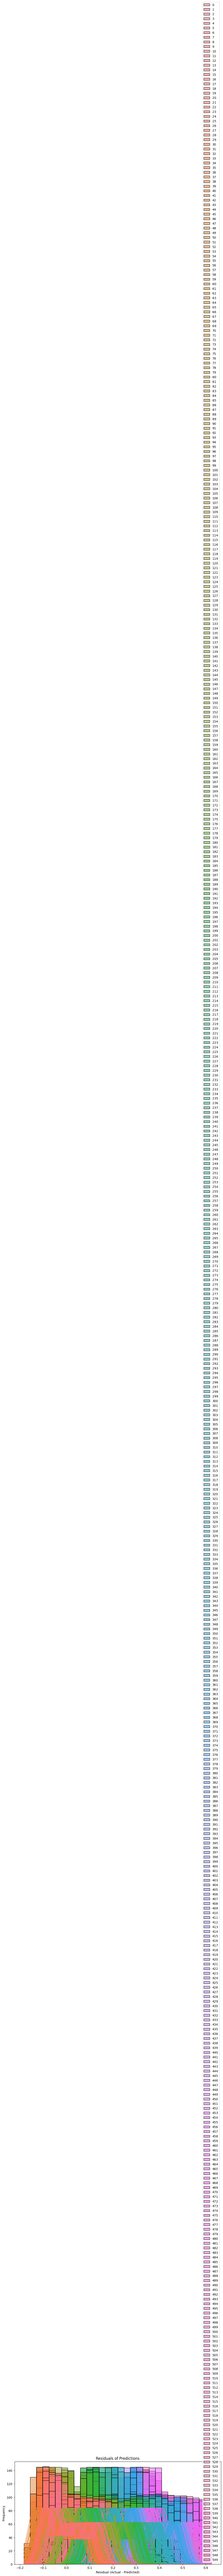

In [30]:
# Calculate residuals
residuals = y_test - predictions

# Plot residuals
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, color="purple", bins=30)
plt.title('Residuals of Predictions')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()


3. Scatter Plot with Regression Line
This scatter plot shows the actual vs. predicted values with a regression line to indicate how well predictions align with actual values.

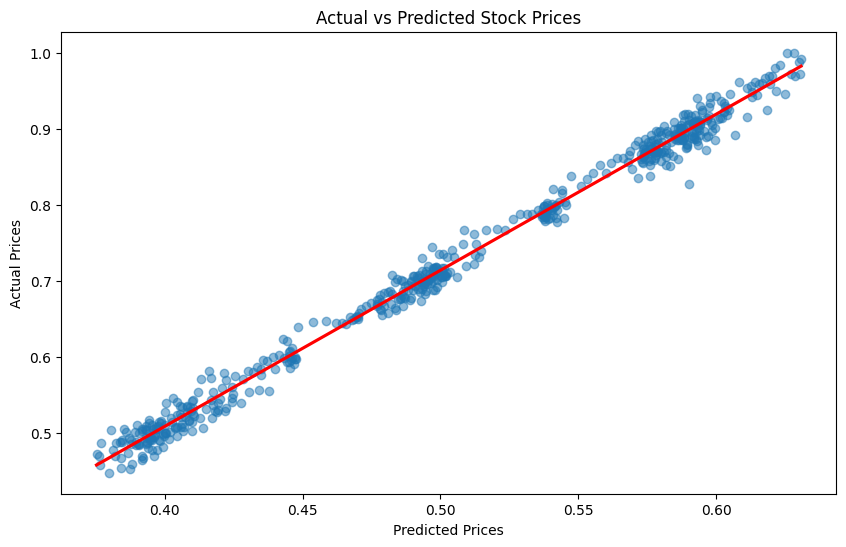

In [31]:
plt.figure(figsize=(10, 6))
sns.regplot(x=predictions, y=y_test, line_kws={"color": "red"}, scatter_kws={"alpha":0.5})
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Predicted Prices')
plt.ylabel('Actual Prices')
plt.show()


## 4. Box Plot of Prediction Errors Over Time Segments
Using box plots for prediction errors over time segments (e.g., quarterly or monthly) can help identify periods with higher volatility or error.

<ipython-input-32-723f942ec757>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Time Segment', y='Error', data=df, palette="Set2")


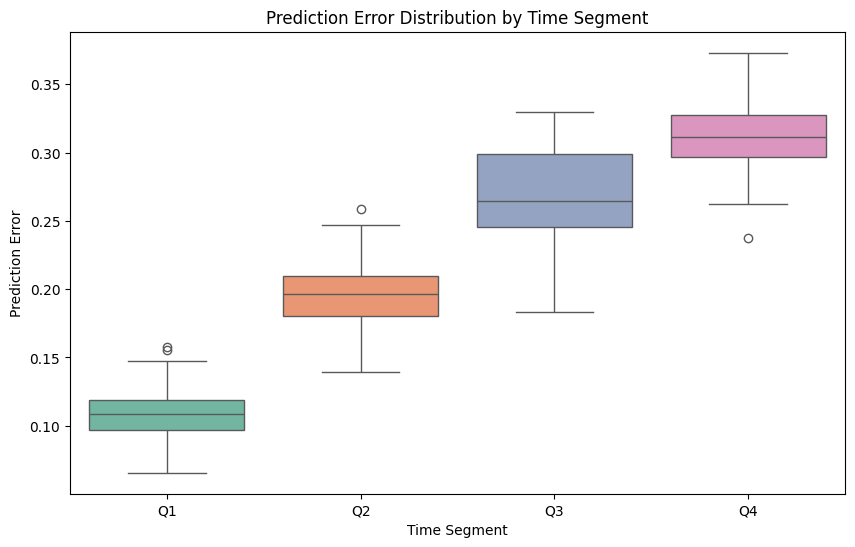

In [32]:
# Add a time segment column (e.g., quarters)
df['Time Segment'] = pd.cut(df['Time Step'], bins=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Calculate errors
df['Error'] = abs(df['Actual Prices'] - df['Predicted Prices'])

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Time Segment', y='Error', data=df, palette="Set2")
plt.title('Prediction Error Distribution by Time Segment')
plt.xlabel('Time Segment')
plt.ylabel('Prediction Error')
plt.show()


## 4. Joint Plot of Actual vs Predicted with Distribution
This combined scatter plot and distribution plot visually compares actual vs. predicted values, showing their distributions along with the joint relationship.

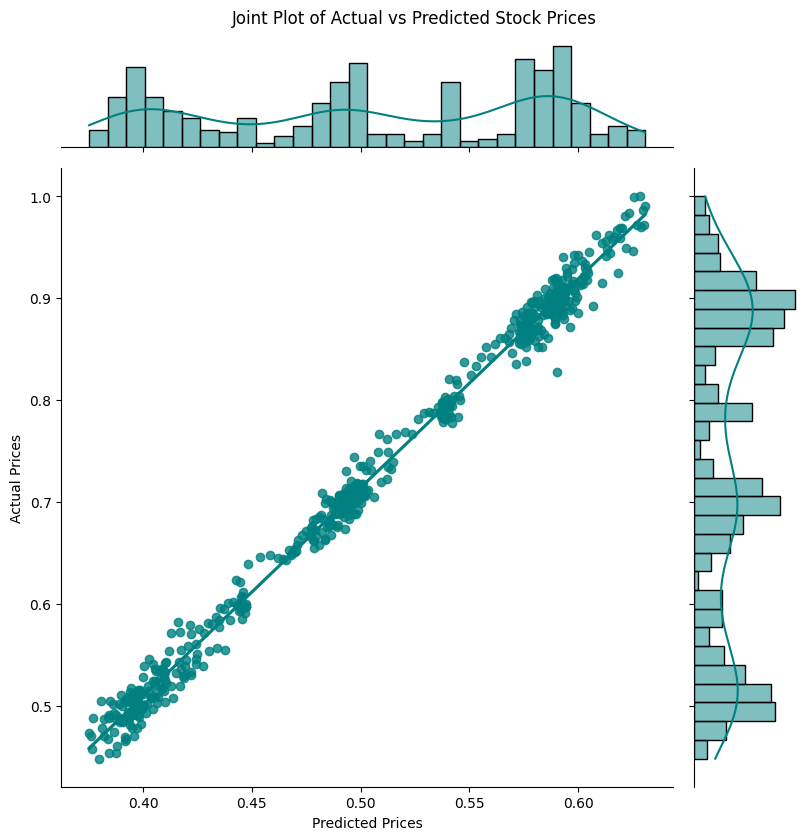

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming predictions or y_test is multi-dimensional, flatten it:
predictions = predictions.flatten()  # If predictions is multi-dimensional
y_test = y_test.flatten()  # If y_test is multi-dimensional

sns.jointplot(x=predictions, y=y_test, kind='reg', height=8, marginal_kws=dict(bins=30, fill=True), color='teal')
plt.suptitle('Joint Plot of Actual vs Predicted Stock Prices', y=1.02)
plt.xlabel('Predicted Prices')
plt.ylabel('Actual Prices')
plt.show()

## Rolling Mean of Absolute Prediction Errors
A rolling mean can provide insights into trends in the prediction error over time, smoothing out short-term fluctuations.

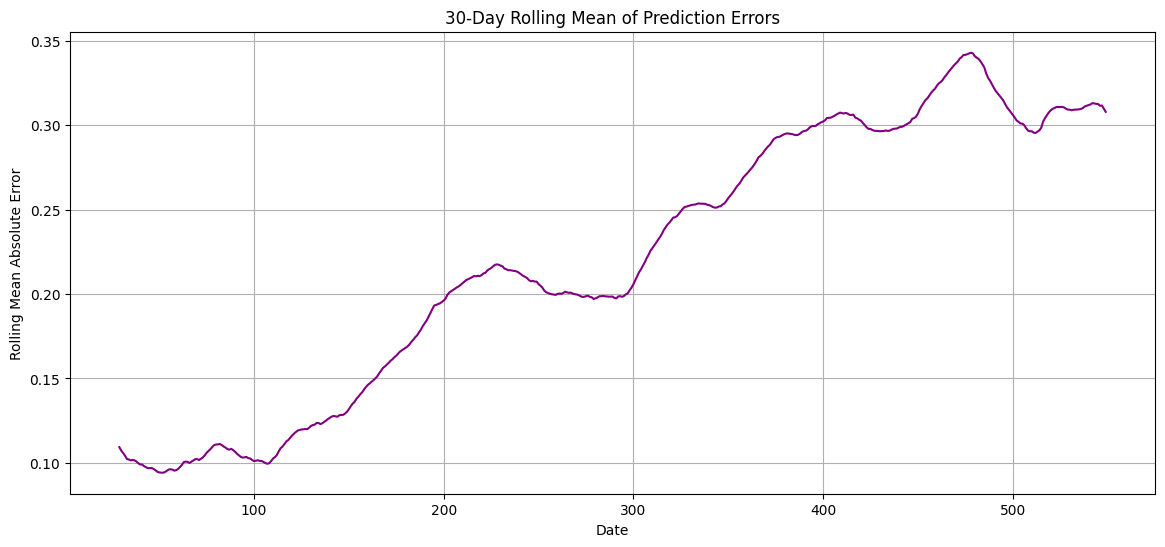

In [34]:
# Calculate rolling mean of the prediction errors
df['Rolling Error'] = df['Error'].rolling(window=30).mean()  # 30-day rolling window

# Plot rolling mean of errors
plt.figure(figsize=(14, 6))
sns.lineplot(x=df.index, y='Rolling Error', data=df, color='purple')
plt.title('30-Day Rolling Mean of Prediction Errors')
plt.xlabel('Date')
plt.ylabel('Rolling Mean Absolute Error')
plt.grid(True)
plt.show()


## Cumulative Returns Plot for Actual vs Predicted
Plotting cumulative returns based on actual and predicted prices can help illustrate whether the model would have matched the trends over time.

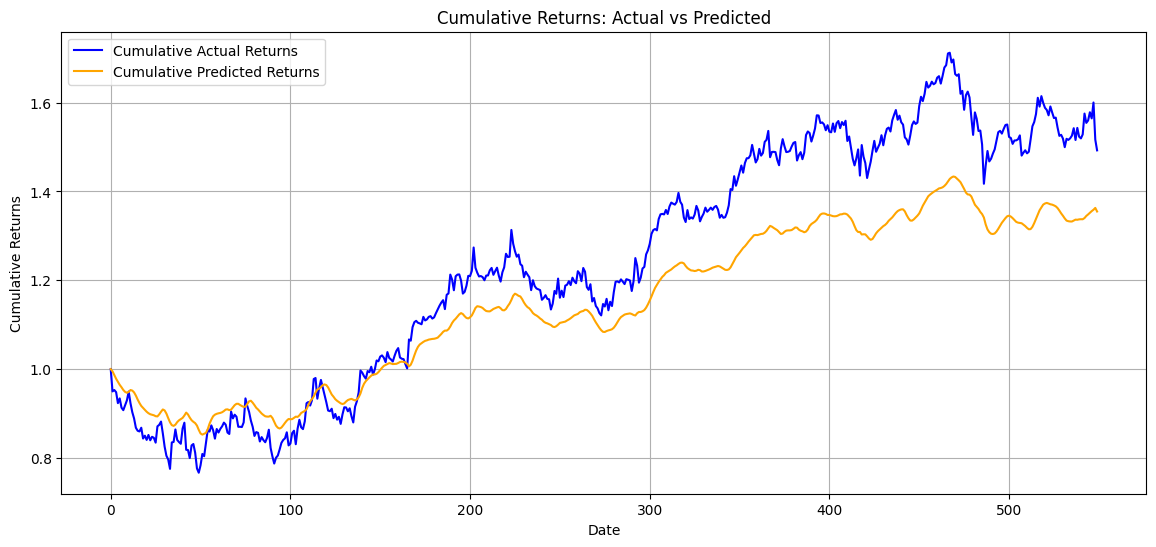

In [35]:
# Calculate daily returns and cumulative returns
df['Actual Returns'] = df['Actual Prices'].pct_change().fillna(0)
df['Predicted Returns'] = df['Predicted Prices'].pct_change().fillna(0)
df['Cumulative Actual'] = (1 + df['Actual Returns']).cumprod()
df['Cumulative Predicted'] = (1 + df['Predicted Returns']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(14, 6))
sns.lineplot(x=df.index, y='Cumulative Actual', data=df, label='Cumulative Actual Returns', color='blue')
sns.lineplot(x=df.index, y='Cumulative Predicted', data=df, label='Cumulative Predicted Returns', color='orange')
plt.title('Cumulative Returns: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


## Error Density Plot
A density plot of the errors can help show the distribution of errors and if they are centered around zero, which would be ideal for unbiased predictions.

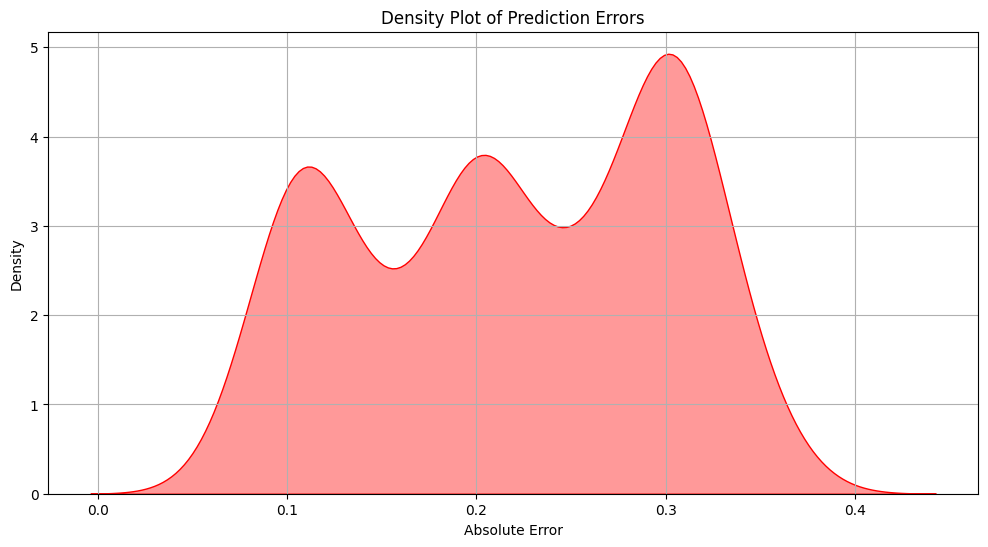

In [36]:
plt.figure(figsize=(12, 6))
sns.kdeplot(df['Error'], color='red', fill=True, alpha=0.4)
plt.title('Density Plot of Prediction Errors')
plt.xlabel('Absolute Error')
plt.ylabel('Density')
plt.grid(True)
plt.show()


## Time Series Plot with Actual, Predicted, and Error as Shaded Area
A time series plot with a shaded area for error provides a straightforward view of the performance over time and highlights periods of higher discrepancy.

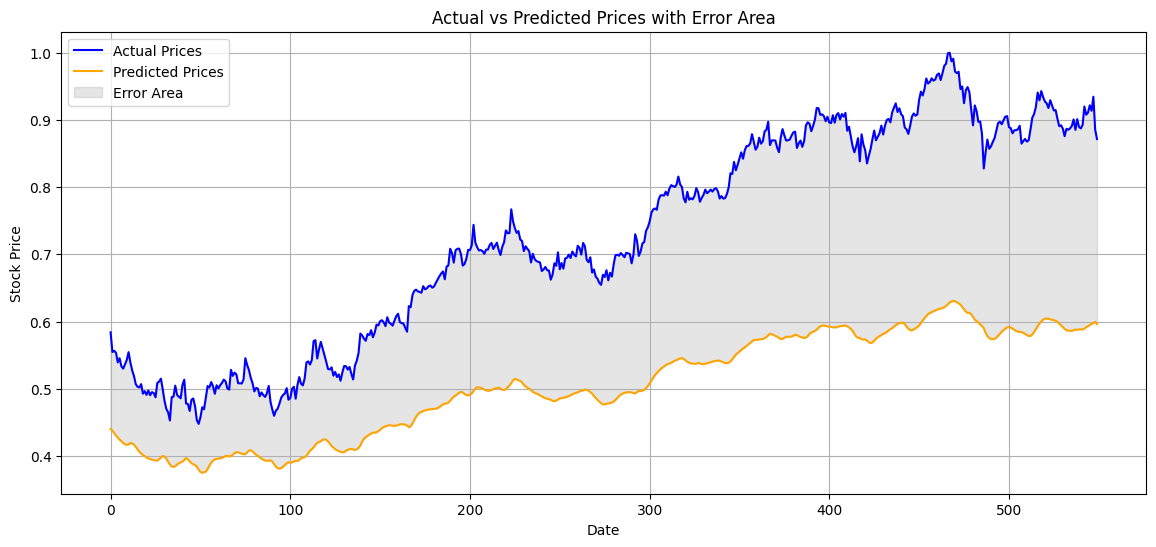

In [37]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=df.index, y='Actual Prices', data=df, label='Actual Prices', color='blue')
sns.lineplot(x=df.index, y='Predicted Prices', data=df, label='Predicted Prices', color='orange')
plt.fill_between(df.index, df['Actual Prices'], df['Predicted Prices'], color='gray', alpha=0.2, label='Error Area')
plt.title('Actual vs Predicted Prices with Error Area')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


# Interactive

In [38]:
!pip install plotly


In [39]:
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd

# Ensure all arrays have the same length
num_data_points = min(len(y_test.flatten()), len(predictions.flatten()), 100)  # Use the minimum length

# Create a dataframe with sample data for demonstration
df = pd.DataFrame({
    'Date': pd.date_range(start='2022-01-01', periods=num_data_points),  # Adjust the periods
    'Actual Prices': y_test.flatten()[:num_data_points],  # Slice to match length
    'Predicted Prices': predictions.flatten()[:num_data_points]  # Slice to match length
})

# Create an interactive line chart
fig = go.Figure()

fig.add_trace(go.Scatter(x=df['Date'], y=df['Actual Prices'], mode='lines', name='Actual Prices'))
fig.add_trace(go.Scatter(x=df['Date'], y=df['Predicted Prices'], mode='lines', name='Predicted Prices'))

fig.update_layout(
    title="Interactive Actual vs Predicted Prices",
    xaxis_title="Date",
    yaxis_title="Stock Price"
)
fig.show()

## Bokeh for Interactive Dashboards and Widgets
Bokeh is ideal for building interactive dashboards and linking multiple plots with sliders, dropdowns, and other widgets.

In [40]:
!pip install bokeh


In [41]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Slider
from bokeh.layouts import column
from bokeh.io import push_notebook

output_notebook()

# Create a ColumnDataSource, converting range to a list
source = ColumnDataSource(data=dict(x=list(range(len(y_test))), actual=y_test.flatten(), predicted=predictions.flatten()))

# Create a figure
p = figure(title="Bokeh Interactive Line Chart", x_axis_label="Time Step", y_axis_label="Stock Price", width=700, height=400)
p.line('x', 'actual', source=source, legend_label="Actual Prices", line_width=2, color="blue")
p.line('x', 'predicted', source=source, legend_label="Predicted Prices", line_width=2, color="orange")

show(p, notebook_handle=True)

## ipywidgets for Interactive Controls in Jupyter Notebooks
ipywidgets can be used with Matplotlib, Plotly, or Bokeh to create interactive widgets like sliders, dropdowns, and checkboxes.

In [42]:
!pip install ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.2 MB/s eta 0:00:00


In [43]:
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

# Interactive plot function
def plot_with_window(window=30):
    # Plot rolling mean of errors
    plt.figure(figsize=(14, 6))
    df['Rolling Error'] = df['Error'].rolling(window=window).mean()
    plt.plot(df.index, df['Rolling Error'], color='purple')
    plt.title(f'Rolling Mean of Prediction Errors (Window = {window})')
    plt.xlabel('Date')
    plt.ylabel('Mean Absolute Error')
    plt.show()

# Create a slider widget to adjust the window size
interact(plot_with_window, window=widgets.IntSlider(min=5, max=60, step=5, value=30))


interactive(children=(IntSlider(value=30, description='window', max=60, min=5, step=5), Output()), _dom_classe…

<function __main__.plot_with_window(window=30)>

<Figure size 1400x600 with 0 Axes>

## Dash for Interactive Web Apps
Dash, based on Plotly, is a framework for building full-fledged interactive web applications in Python, suitable for hosting dashboards.

In [44]:
!pip install dash


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 24.6 MB/s eta 0:00:00


In [45]:
from dash import Dash, dcc, html, dependencies # Import dependencies
import plotly.graph_objs as go

# Create the Dash app
app = Dash(__name__)

# Set up the layout with dropdown for selecting different stocks
app.layout = html.Div([
    html.H1("Stock Prediction Dashboard"),
    dcc.Graph(id='stock-graph'),
    dcc.Slider(
        id='window-slider',
        min=5,
        max=60,
        step=5,
        value=30,
        marks={i: str(i) for i in range(5, 61, 5)}
    )
])

@app.callback(
    dependencies.Output('stock-graph', 'figure'), # Use dependencies instead of dash.dependencies
    [dependencies.Input('window-slider', 'value')] # Use dependencies instead of dash.dependencies
)
def update_figure(window):
    df['Rolling Error'] = df['Error'].rolling(window=window).mean()
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df['Rolling Error'], mode='lines', name=f'Rolling Error (Window={window})'))
    fig.update_layout(title='Rolling Mean of Prediction Errors', xaxis_title='Date', yaxis_title='Error')
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

<IPython.core.display.Javascript object>

## 2. Altair for Linked Plots and Time Series Analysis
Altair offers a simple, declarative way to create interactive visualizations, including linked plots.

In [46]:
!pip install altair


---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py in get_loc(
    self=Index(['Date', 'Actual Prices', 'Predicted Prices'], dtype='object'),
    key='Error'
)
   3804         try:
-> 3805             return self._engine.get_loc(casted_key)
        self._engine.get_loc = <bound method IndexEngine.get_loc of <pandas._libs.index.ObjectEngine object at 0x7e8fc9acc6a0>>
        casted_key = 'Error'
   3806         except KeyError as err:

index.pyx in pandas._libs.index.IndexEngine.get_loc()

index.pyx in pandas._libs.index.IndexEngine.get_loc()

pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

KeyError: 'Error'

The above exception was the direct cause of the following exception:

K

In [47]:
import altair as alt

# Create a dataframe for Altair
alt_df = pd.DataFrame({
    'Time Step': range(len(y_test)),
    'Actual Prices': y_test.flatten(),
    'Predicted Prices': predictions.flatten()
})

# Plot with interactive tooltips
line_chart = alt.Chart(alt_df).mark_line().encode(
    x='Time Step',
    y=alt.Y('Actual Prices', title='Stock Price'),
    tooltip=['Time Step', 'Actual Prices', 'Predicted Prices']
).properties(
    title='Interactive Actual vs Predicted Prices'
).interactive()

line_chart.display()


alt.Chart(...)

## Line Plot of Closing Prices Over Time
This plot shows the daily closing price trends over time for each stock.

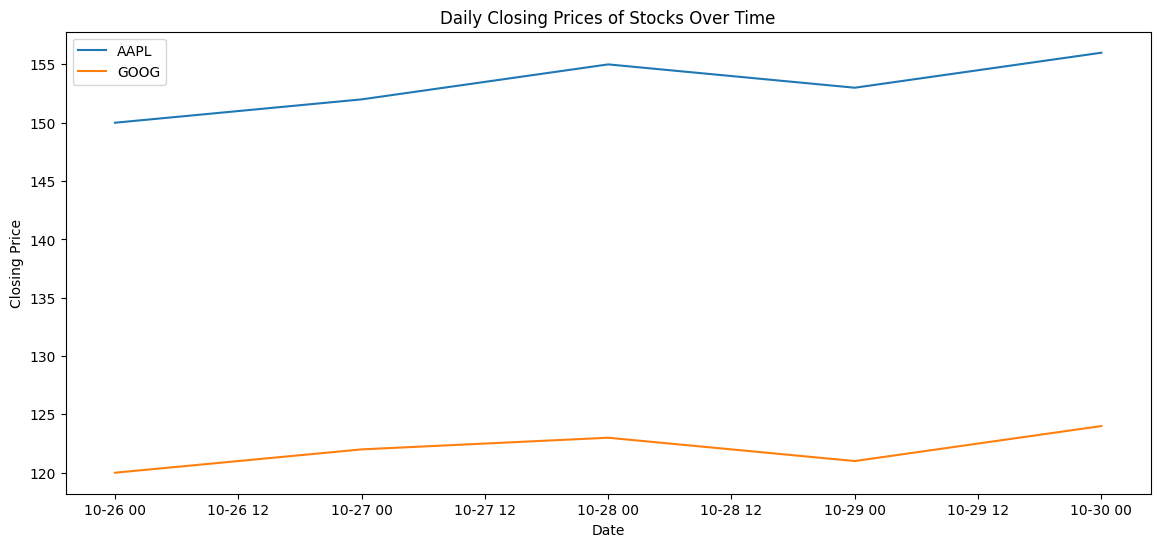

In [48]:
import matplotlib.pyplot as plt # Import the pyplot module from matplotlib
import pandas as pd # Assuming stock data are in Pandas DataFrames

# **Create sample stock_data dictionary if not already defined**
# Replace with your actual stock data loading logic
stock_data = {
    'AAPL': pd.DataFrame({'Close': [150, 152, 155, 153, 156]}, index=pd.date_range('2023-10-26', periods=5)),
    'GOOG': pd.DataFrame({'Close': [120, 122, 123, 121, 124]}, index=pd.date_range('2023-10-26', periods=5))
}

plt.figure(figsize=(14, 6))
for symbol, df in stock_data.items():
    plt.plot(df.index, df['Close'], label=symbol)
plt.title('Daily Closing Prices of Stocks Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

## Moving Average Plot
Overlay the 50-day and 200-day moving averages on the closing prices for trend analysis.

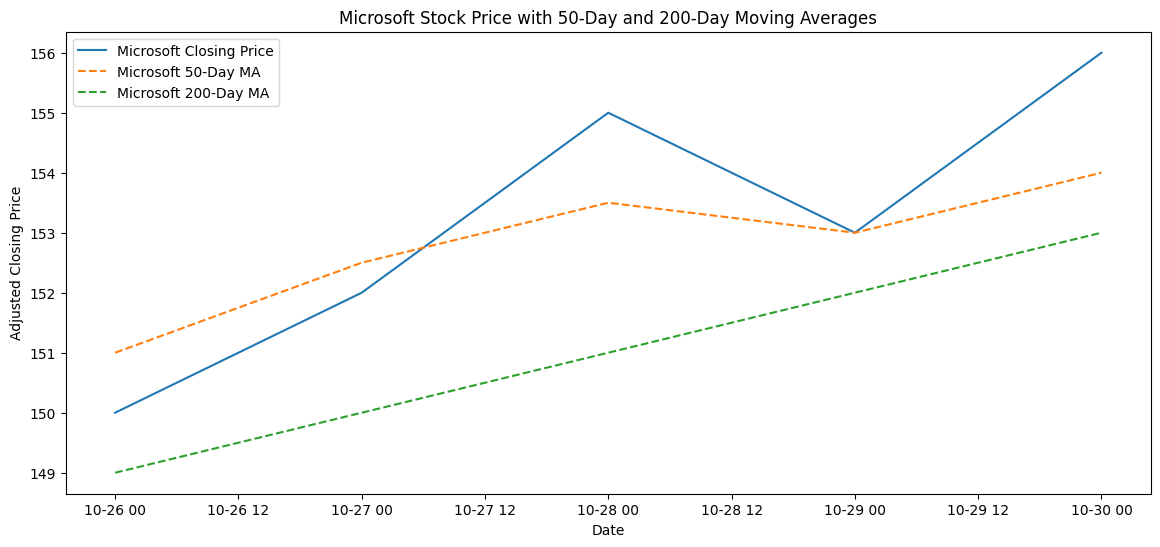

In [49]:
import matplotlib.pyplot as plt # Import the pyplot module from matplotlib
import pandas as pd # Assuming stock data are in Pandas DataFrames

# **Create a sample DataFrame for msft_data (Replace with your actual data loading)**
msft_data = pd.DataFrame({
    '5. adjusted close': [150, 152, 155, 153, 156],
    'MA_50': [151, 152.5, 153.5, 153, 154],
    'MA_200': [149, 150, 151, 152, 153]
}, index=pd.date_range('2023-10-26', periods=5))  # Assuming you have a date index

plt.figure(figsize=(14, 6))
plt.plot(msft_data.index, msft_data['5. adjusted close'], label='Microsoft Closing Price')
plt.plot(msft_data.index, msft_data['MA_50'], label='Microsoft 50-Day MA', linestyle='--')
plt.plot(msft_data.index, msft_data['MA_200'], label='Microsoft 200-Day MA', linestyle='--')
plt.title('Microsoft Stock Price with 50-Day and 200-Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price')
plt.legend()
plt.show()

## Volume Traded as a Bar Plot
This bar plot shows the daily trading volume, useful for spotting spikes in trading activity.

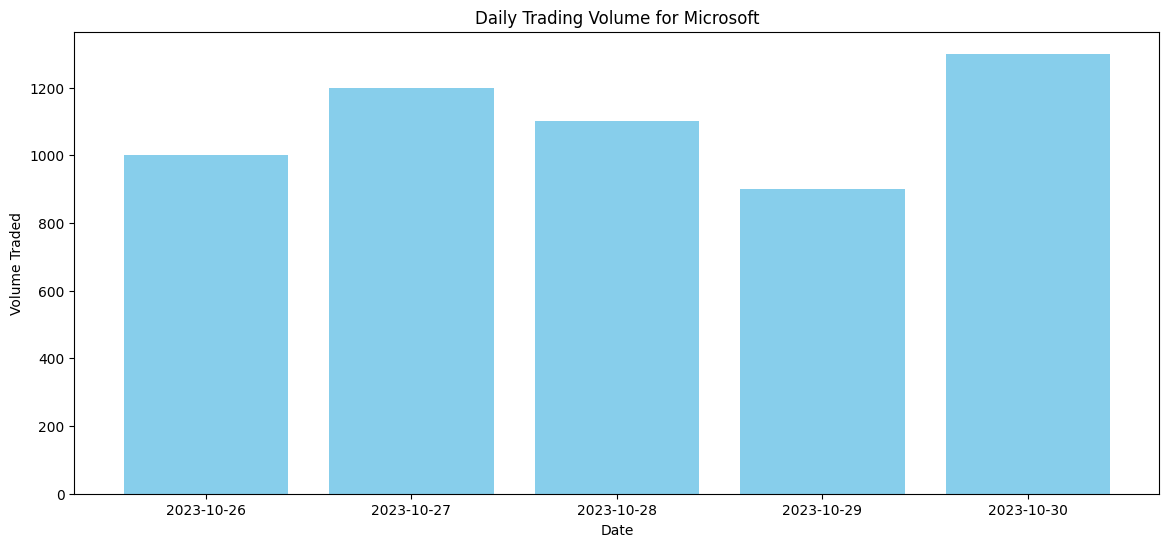

In [50]:
import matplotlib.pyplot as plt # Import the pyplot module from matplotlib
import pandas as pd # Assuming stock data are in Pandas DataFrames

# **Create a sample DataFrame for msft_data (Replace with your actual data loading)**
# Ensure that '6. volume' is included as a column in the DataFrame
msft_data = pd.DataFrame({
    '5. adjusted close': [150, 152, 155, 153, 156],
    'MA_50': [151, 152.5, 153.5, 153, 154],
    'MA_200': [149, 150, 151, 152, 153],
    '6. volume': [1000, 1200, 1100, 900, 1300]  # Example volume data
}, index=pd.date_range('2023-10-26', periods=5))  # Assuming you have a date index

plt.figure(figsize=(14, 6))
plt.bar(msft_data.index, msft_data['6. volume'], color='skyblue') # Access volume data using '6. volume'
plt.title('Daily Trading Volume for Microsoft')
plt.xlabel('Date')
plt.ylabel('Volume Traded')
plt.show()

## Box Plot of Daily Returns
This plot displays the distribution of daily returns to analyze stock volatility.

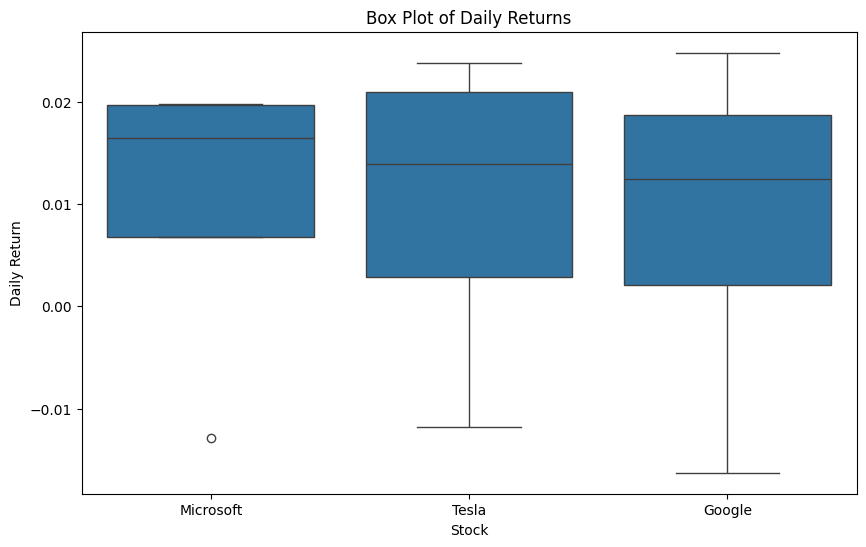

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns  # Make sure to import seaborn

# Calculate daily returns
tsla_data = pd.DataFrame({
    '5. adjusted close': [250, 255, 252, 258, 260],
    # ... other columns if needed ...
}, index=pd.date_range('2023-10-26', periods=5))

googl_data = pd.DataFrame({
    '5. adjusted close': [120, 122, 123, 121, 124],
    # ... other columns if needed ...
}, index=pd.date_range('2023-10-26', periods=5))

# Calculate daily returns
msft_data['Daily Return'] = msft_data['5. adjusted close'].pct_change().dropna()
tsla_data['Daily Return'] = tsla_data['5. adjusted close'].pct_change().dropna()
googl_data['Daily Return'] = googl_data['5. adjusted close'].pct_change().dropna()

# Combine data for Seaborn
returns_df = pd.DataFrame({
    'Microsoft': msft_data['Daily Return'],
    'Tesla': tsla_data['Daily Return'],
    'Google': googl_data['Daily Return']
}).melt(var_name='Stock', value_name='Daily Return')

# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Stock', y='Daily Return', data=returns_df)
plt.title('Box Plot of Daily Returns')
plt.xlabel('Stock')
plt.ylabel('Daily Return')
plt.show()

## Correlation Heatmap of Daily Returns
This heatmap shows the correlation between daily returns for each stock.

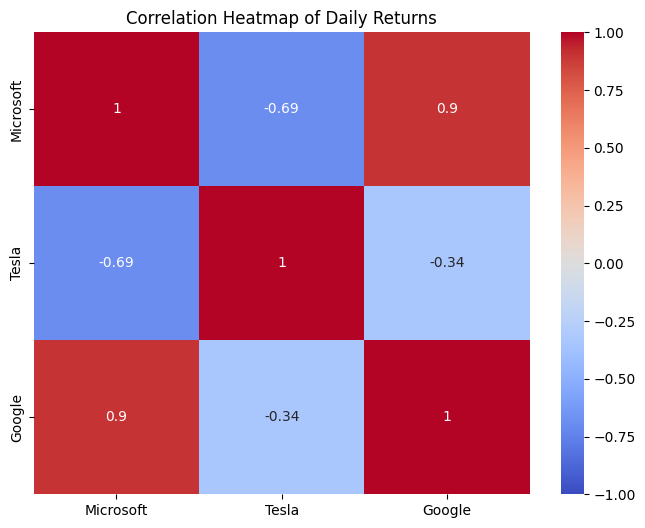

In [52]:
# Calculate daily returns and correlation
daily_returns = pd.DataFrame({
    'Microsoft': msft_data['Daily Return'],
    'Tesla': tsla_data['Daily Return'],
    'Google': googl_data['Daily Return']
}).dropna()
corr_matrix = daily_returns.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Daily Returns')
plt.show()


## Pair Plot of Stock Prices
The pair plot shows the relationship between stock prices for Microsoft, Tesla, and Google.

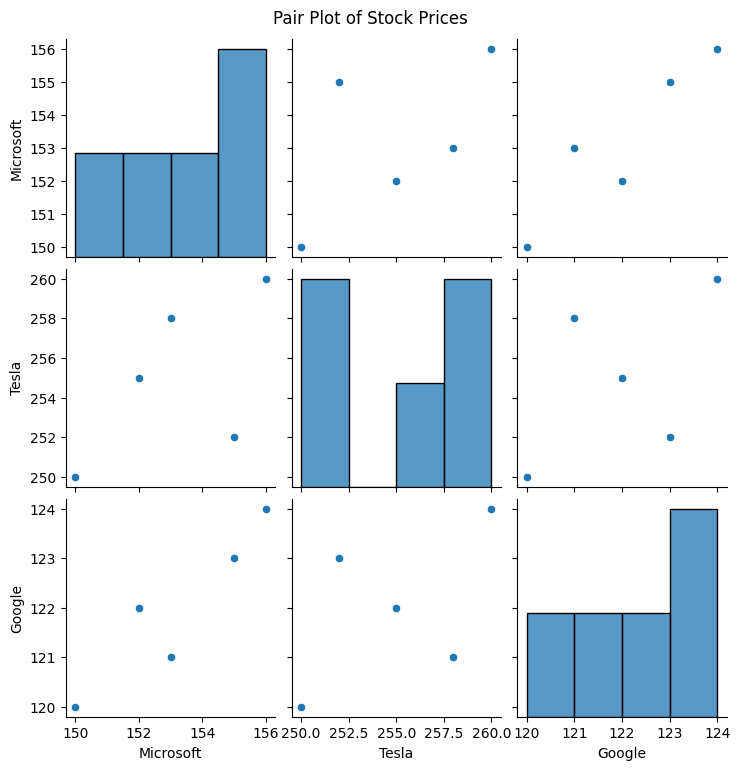

In [53]:
# Create a data frame with closing prices

closing_prices = pd.DataFrame({
    'Microsoft': msft_data['5. adjusted close'],
    'Tesla': tsla_data['5. adjusted close'],
    'Google': googl_data['5. adjusted close']
}).dropna()

# Pair plot
sns.pairplot(closing_prices)
plt.suptitle('Pair Plot of Stock Prices', y=1.02)
plt.show()


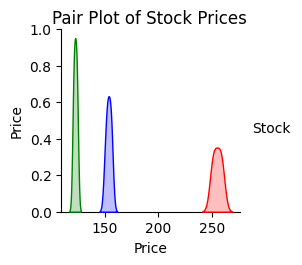

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Reshape data to include a 'Stock' column for color differentiation
closing_prices = pd.DataFrame({
    'Microsoft': msft_data['5. adjusted close'],
    'Tesla': tsla_data['5. adjusted close'],
    'Google': googl_data['5. adjusted close']
}).dropna()

# Reset the index and rename the index column to 'date'
closing_prices = closing_prices.reset_index().rename(columns={'index': 'date'})

# Melt the data to long format for hue in pairplot
closing_prices_melted = closing_prices.melt(id_vars='date', var_name='Stock', value_name='Price')

# Create pair plot with different colors for each stock
sns.pairplot(closing_prices_melted, hue='Stock', palette={'Microsoft': 'blue', 'Tesla': 'red', 'Google': 'green'}, markers=["o", "s", "D"])
plt.suptitle('Pair Plot of Stock Prices', y=1.02)
plt.show()

## Density Plot of Daily Returns
A KDE plot shows the probability distribution of daily returns, useful for understanding stock volatility.

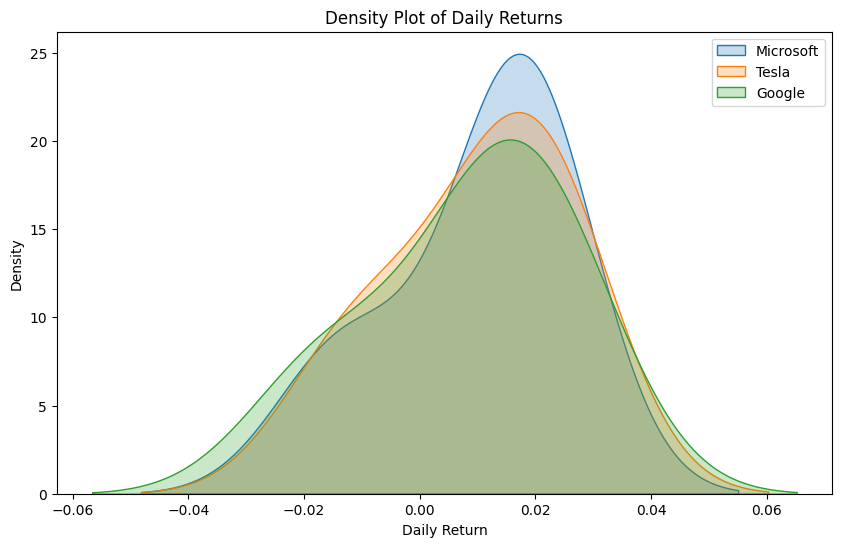

In [55]:
plt.figure(figsize=(10, 6))
sns.kdeplot(msft_data['Daily Return'], label='Microsoft', fill=True)
sns.kdeplot(tsla_data['Daily Return'], label='Tesla', fill=True)
sns.kdeplot(googl_data['Daily Return'], label='Google', fill=True)
plt.title('Density Plot of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend()
plt.show()


## Rolling Volatility Plot
Plotting rolling volatility over time to analyze how the stock’s price stability changes.

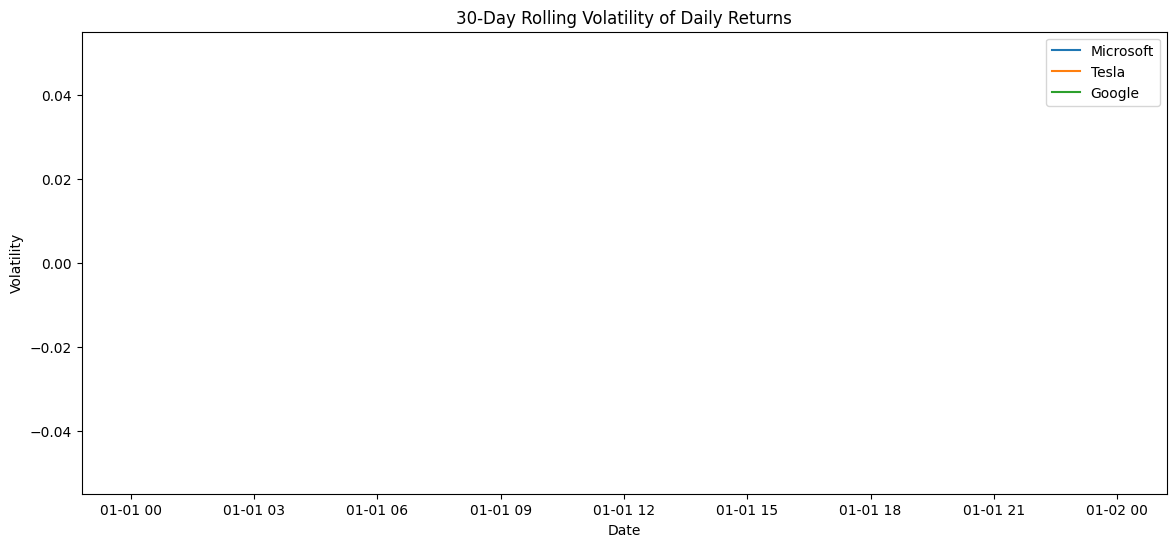

In [56]:
# Calculate 30-day rolling standard deviation (volatility) of daily returns
msft_data['Volatility'] = msft_data['Daily Return'].rolling(window=30).std()
tsla_data['Volatility'] = tsla_data['Daily Return'].rolling(window=30).std()
googl_data['Volatility'] = googl_data['Daily Return'].rolling(window=30).std()


plt.figure(figsize=(14, 6))
plt.plot(msft_data.index, msft_data['Volatility'], label='Microsoft')
plt.plot(tsla_data.index, tsla_data['Volatility'], label='Tesla')
plt.plot(googl_data.index, googl_data['Volatility'], label='Google')
plt.title('30-Day Rolling Volatility of Daily Returns')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


## Candlestick Chart for Stock Price
A candlestick chart offers an in-depth view of daily stock prices, including open, high, low, and close.

In [57]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.1 MB/s eta 0:00:00


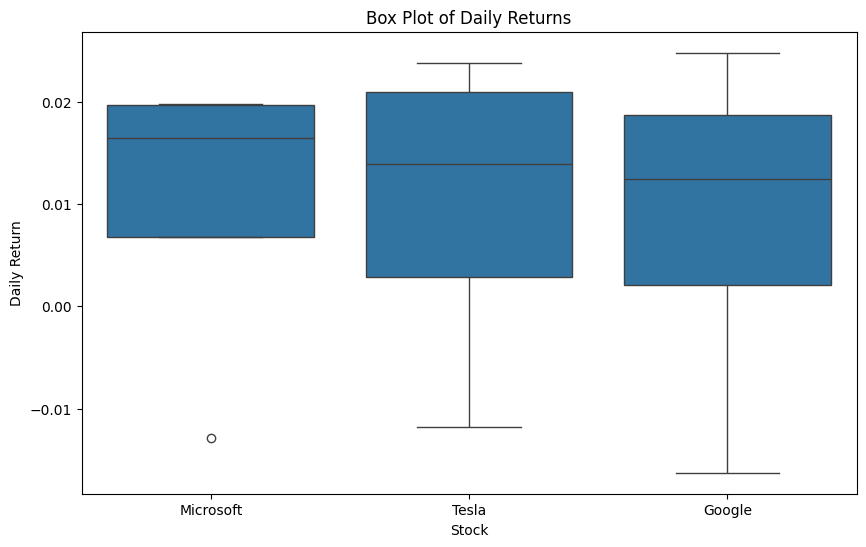

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

# Load data
# msft_data = pd.read_csv('MSFT_stock_data_with_indicators.csv', index_col='date', parse_dates=True)

# Calculate daily returns
msft_data['Daily Return'] = msft_data['5. adjusted close'].pct_change().dropna()
tsla_data['Daily Return'] = tsla_data['5. adjusted close'].pct_change().dropna() # tsla_data is defined and accessible here
googl_data['Daily Return'] = googl_data['5. adjusted close'].pct_change().dropna()

# Combine data for Seaborn
returns_df = pd.DataFrame({
    'Microsoft': msft_data['Daily Return'],
    'Tesla': tsla_data['Daily Return'],
    'Google': googl_data['Daily Return']
}).melt(var_name='Stock', value_name='Daily Return')

# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Stock', y='Daily Return', data=returns_df)
plt.title('Box Plot of Daily Returns')
plt.xlabel('Stock')
plt.ylabel('Daily Return')
plt.show()

# Interactive stock analyzer
To create an Interactive stock analyzer, we used Plotly Dash to build a web-based interactive applications with sliders, dropdowns, and more.

The simple dashboard below allows users the ability to select different stocks, view the stock’s daily prices, and add overlays like moving averages.

Code for an Interactive Stock Analyzer with Dash
Installation

First, ensure you have Plotly and Dash installed:
!pip install dash dash-core-components dash-html-components dash-bootstrap-components plotly

Dash App Code
The following code sets up a basic interactive stock analyzer dashboard that shows stock prices and moving averages for Microsoft, Tesla, and Google.

In [59]:
!pip install dash dash-core-components dash-html-components dash-bootstrap-components plotly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 kB 3.9 MB/s eta 0:00:00


In [60]:
import pandas as pd
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objs as go

# Load stock data
msft_data = pd.read_csv('MSFT_stock_data_with_indicators.csv', index_col='date', parse_dates=True)
tsla_data = pd.read_csv('TSLA_stock_data_with_indicators.csv', index_col='date', parse_dates=True)
googl_data = pd.read_csv('GOOGL_stock_data_with_indicators.csv', index_col='date', parse_dates=True)

# Combine data for easy access
stock_data = {
    'Microsoft': msft_data,
    'Tesla': tsla_data,
    'Google': googl_data
}

# Create Dash app
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Interactive Stock Analyzer"),

    html.Label("Select Stock:"),
    dcc.Dropdown(
        id='stock-dropdown',
        options=[{'label': key, 'value': key} for key in stock_data.keys()],
        value='Microsoft'  # Default stock
    ),

    html.Label("Moving Averages:"),
    dcc.Checklist(
        id='ma-checklist',
        options=[
            {'label': '50-Day MA', 'value': 'MA_50'},
            {'label': '200-Day MA', 'value': 'MA_200'}
        ],
        value=['MA_50'],  # Default moving average selected
        inline=True
    ),

    dcc.Graph(id='stock-graph'),

    html.Hr(),

    # Additional indicator section
    html.Div([
        html.H4("Stock Volume Over Time"),
        dcc.Graph(id='volume-graph')
    ])
])

@app.callback(
    [Output('stock-graph', 'figure'),
     Output('volume-graph', 'figure')],
    [Input('stock-dropdown', 'value'),
     Input('ma-checklist', 'value')]
)
def update_graph(stock_name, selected_mas):
    df = stock_data[stock_name]

    # Stock Price Graph
    price_fig = go.Figure()
    price_fig.add_trace(go.Scatter(x=df.index, y=df['5. adjusted close'], mode='lines', name='Adjusted Close'))

    # Add moving averages if selected
    for ma in selected_mas:
        price_fig.add_trace(go.Scatter(x=df.index, y=df[ma], mode='lines', name=f"{ma}"))

    price_fig.update_layout(
        title=f"{stock_name} Stock Price",
        xaxis_title="Date",
        yaxis_title="Price (USD)",
        template="plotly_white"
    )

    # Volume Graph
    volume_fig = go.Figure()
    volume_fig.add_trace(go.Bar(x=df.index, y=df['6. volume'], name='Volume', marker_color='blue'))
    volume_fig.update_layout(
        title=f"{stock_name} Daily Volume",
        xaxis_title="Date",
        yaxis_title="Volume",
        template="plotly_white"
    )

    return price_fig, volume_fig

# Run app
if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>